<a href="https://colab.research.google.com/github/Juanchi97/CoderHouseDataScienceIII/blob/main/ProyectoFinal_DataScienceIII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Final: Análisis NLP del Capítulo II - El pueblo Ona: Vida y Muerte

## **Cultura Selk’nam en Tierra del Fuego**

## **Autor**: Gutierrez Juan Carlos

## **Fecha**: 26 de julio de 2025

## **Contexto**: Este proyecto analiza el Capítulo II del libro *Culturas tradicionales - Patagonia: fin de un mundo: los Selk’nam de Tierra del Fuego* por Anne Chapman, utilizando técnicas avanzadas de procesamiento de lenguaje natural (NLP). El objetivo es extraer información clave sobre la vida, espiritualidad y desaparición cultural de los Selk’nam, generando visualizaciones impactantes.

## **Contexto personal**: Elegí este tema porque nací y crecí en Tierra del Fuego y siento un profundo respeto por la historia y cultura de los Selk’nam. Esta tierra guarda y honra su memoria de muchas formas —a través del arte, la música, la lectura— y hoy también desde la tecnología, que avanza a pasos agigantados. Con este proyecto busco rendir homenaje a ese legado, usando las herramientas del presente para mantener viva la memoria del pasado.

# 1. Instalación de dependencias

Instalamos las bibliotecas necesarias para el análisis NLP y visualizaciones.

In [2]:
!pip install pdfplumber spacy nltk gensim wordcloud textblob vaderSentiment matplotlib seaborn plotly folium
!python -m spacy download es_core_news_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.0/568.0 MB 3.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# 2. Importación de bibliotecas

In [1]:
import pdfplumber
import spacy
import nltk
from nltk.corpus import stopwords
import re
from google.colab import files
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns
import plotly.express as px
import pandas as pd
import folium
from folium.plugins import MarkerCluster
import warnings
warnings.filterwarnings('ignore')

## Descargar recursos de NLTK

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Cargar modelo de SpaCy

In [4]:
nlp = spacy.load("es_core_news_lg")

## Inicializar VADER para análisis

In [5]:
analyzer = SentimentIntensityAnalyzer()

# 3. Extracción del texto del PDF

## Extraemos el texto de las páginas 41-84 del PDF *Culturas tradicionales* (Capítulo II).

In [12]:
def limpiar_texto_ocr(texto):
    """Limpia errores comunes de OCR y normaliza el texto."""
    texto = texto.replace('CHAMANICOSY', 'CHAMÁNICOS Y')
    texto = texto.replace('SELK\'NAM', 'SELK’NAM')
    texto = texto.replace('MUNO', 'MUNDO')
    texto = re.sub(r'[^\w\s.,;:!?áéíóúÁÉÍÓÚñÑ]', '', texto)
    texto = re.sub(r'\s+', ' ', texto)
    return texto.strip()

print("Sube el archivo 'Culturas tradicionales.pdf'")
uploaded = files.upload()
pdf_filename = list(uploaded.keys())[0]


Sube el archivo 'Culturas tradicionales.pdf'


Saving Culturas tradicionales.pdf to Culturas tradicionales (1).pdf


## Extraer texto de las páginas 41-84

In [13]:
with pdfplumber.open(pdf_filename) as pdf:
    texto = ''
    for page in pdf.pages[40:84]:  # Páginas 41-84 (índice 0-based)
        page_text = page.extract_text()
        if page_text:
            texto += limpiar_texto_ocr(page_text) + '\n\n'

## Guardar el texto extraído

In [14]:
with open('capitulo_ii_selknam_vida_y_muerte.txt', 'w', encoding='utf-8') as f:
    f.write(texto)
files.download('capitulo_ii_selknam_vida_y_muerte.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 4. Carga del texto para análisis

In [15]:
def cargar_texto():
    """Carga el archivo de texto para análisis."""
    print("Sube el archivo 'capitulo_ii_selknam_vida_y_muerte.txt':")
    uploaded = files.upload()
    filename = list(uploaded.keys())[0]
    with open(filename, 'r', encoding='utf-8') as file:
        return file.read()

texto = cargar_texto()

Sube el archivo 'capitulo_ii_selknam_vida_y_muerte.txt':


Saving capitulo_ii_selknam_vida_y_muerte.txt to capitulo_ii_selknam_vida_y_muerte (1).txt


# 5. Preprocesamiento del texto

## Tokenización y limpieza

In [16]:
def limpiar_texto(texto):
    """Tokeniza y limpia el texto, eliminando palabras vacías y puntuación."""
    texto = re.sub(r'[^\w\s.,;:!?áéíóúÁÉÍÓÚñÑ]', '', texto)
    texto = re.sub(r'\s+', ' ', texto)
    doc = nlp(texto)
    stop_words = set(stopwords.words('spanish') + ['si', 'tan', 'vez', 'cada'])
    tokens = [token.text.lower() for token in doc if token.text.lower() not in stop_words and not token.is_punct]
    return tokens

tokens_limpios = limpiar_texto(texto)
print("Primeros 10 tokens limpios:", tokens_limpios[:10])

Primeros 10 tokens limpios: ['fin', 'mundo', 'capitulo', 'ii', 'pueblo', 'ona', 'vida', 'muerte', 'tierra', 'fuego']


## Lematización

In [17]:
def lematizar_texto(tokens):
    """Lematiza los tokens para reducir palabras a su forma base."""
    doc = nlp(' '.join(tokens))
    lemas = [token.lemma_.lower() for token in doc if not token.is_punct]
    return lemas

lemas = lematizar_texto(tokens_limpios)
print("Primeros 10 lemas:", lemas[:10])

Primeros 10 lemas: ['fin', 'mundo', 'capitulo', 'ii', 'pueblo', 'ona', 'vida', 'muerte', 'tierra', 'fuego']


# 6. Análisis de sentimientos

## TextBlob y VADER

In [19]:
def analizar_sentimiento(texto):
    blob = TextBlob(texto)
    polaridad_tb = blob.sentiment.polarity
    subjetividad_tb = blob.sentiment.subjectivity
    sentimiento_tb = "Positivo" if polaridad_tb > 0 else "Negativo" if polaridad_tb < 0 else "Neutro"

    vader_scores = analyzer.polarity_scores(texto)
    polaridad_vd = vader_scores['compound']
    sentimiento_vd = "Positivo" if polaridad_vd > 0.05 else "Negativo" if polaridad_vd < -0.05 else "Neutro"

    return (sentimiento_tb, polaridad_tb, subjetividad_tb, sentimiento_vd, polaridad_vd)

sentimiento_tb, polaridad_tb, subjetividad_tb, sentimiento_vd, polaridad_vd = analizar_sentimiento(texto)
print(f"Análisis de sentimientos:")
print(f"TextBlob: {sentimiento_tb}, Polaridad: {polaridad_tb:.2f}, Subjetividad: {subjetividad_tb:.2f}")
print(f"VADER: {sentimiento_vd}, Polaridad: {polaridad_vd:.2f}")

Análisis de sentimientos:
TextBlob: Positivo, Polaridad: 0.08, Subjetividad: 0.42
VADER: Negativo, Polaridad: -1.00


# 7. Reconocimiento de Entidades Nombradas (NER)

In [20]:
def extraer_entidades(texto):
    doc = nlp(texto)
    entidades = [(ent.text, ent.label_) for ent in doc.ents]
    return entidades

entidades = extraer_entidades(texto)
print("Primeras 10 entidades encontradas:", entidades[:10])

Primeras 10 entidades encontradas: [('FIN DE UN', 'ORG'), ('Ana Montes PRIMERA PARTE', 'PER'), ('VIDA Anne Chapman', 'PER'), ('Kiepja', 'PER'), ('Lola', 'PER'), ('Tierra del Fuego', 'LOC'), ('Kiepja', 'PER'), ('De los pocos sobrevivientes de su grupo', 'MISC'), ('Acampaba', 'PER'), ('Anciana', 'PER')]


# 8. Modelado de temas con LDA

In [21]:
def modelado_temas(lemas, num_temas=5):
    diccionario = corpora.Dictionary([lemas])
    corpus = [diccionario.doc2bow(lemas)]
    lda_model = LdaModel(corpus, num_topics=num_temas, id2word=diccionario, passes=20, alpha='auto', eta='auto', random_state=42)
    temas = lda_model.print_topics(num_words=10)
    # Calcular coherencia del modelo
    coherence_model = CoherenceModel(model=lda_model, texts=[lemas], dictionary=diccionario, coherence='c_v')
    coherencia = coherence_model.get_coherence()
    return temas, lda_model, diccionario, coherencia

temas, lda_model, diccionario, coherencia = modelado_temas(lemas, num_temas=5)
print(f"\nCoherencia del modelo LDA (C_V): {coherencia:.2f}")
for idx, tema in temas:
    print(f"Tema {idx+1}: {tema}")


Coherencia del modelo LDA (C_V): 0.24
Tema 1: 0.009*"grande" + 0.009*"ahí" + 0.009*"chapman" + 0.008*"morir" + 0.008*"ir" + 0.007*"angela" + 0.007*"hacer" + 0.007*"tierra" + 0.007*"selknam" + 0.007*"saber"
Tema 2: 0.001*"grande" + 0.001*"ir" + 0.001*"morir" + 0.001*"angela" + 0.001*"ahí" + 0.001*"año" + 0.001*"chapman" + 0.001*"selknam" + 0.001*"indio" + 0.001*"vida"
Tema 3: 0.001*"ir" + 0.001*"grande" + 0.001*"tierra" + 0.001*"angela" + 0.001*"ahí" + 0.001*"chapman" + 0.001*"poder" + 0.001*"morir" + 0.001*"hacer" + 0.001*"garibaldi"
Tema 4: 0.001*"grande" + 0.001*"garibaldi" + 0.001*"ahí" + 0.001*"hacer" + 0.001*"vivir" + 0.001*"ir" + 0.001*"morir" + 0.001*"tierra" + 0.001*"isla" + 0.001*"selknam"
Tema 5: 0.001*"ahí" + 0.001*"chapman" + 0.001*"grande" + 0.001*"ir" + 0.001*"año" + 0.001*"garibaldi" + 0.001*"angela" + 0.001*"poder" + 0.001*"selknam" + 0.001*"morir"


# 9. Visualizaciones

## Nube de palabras

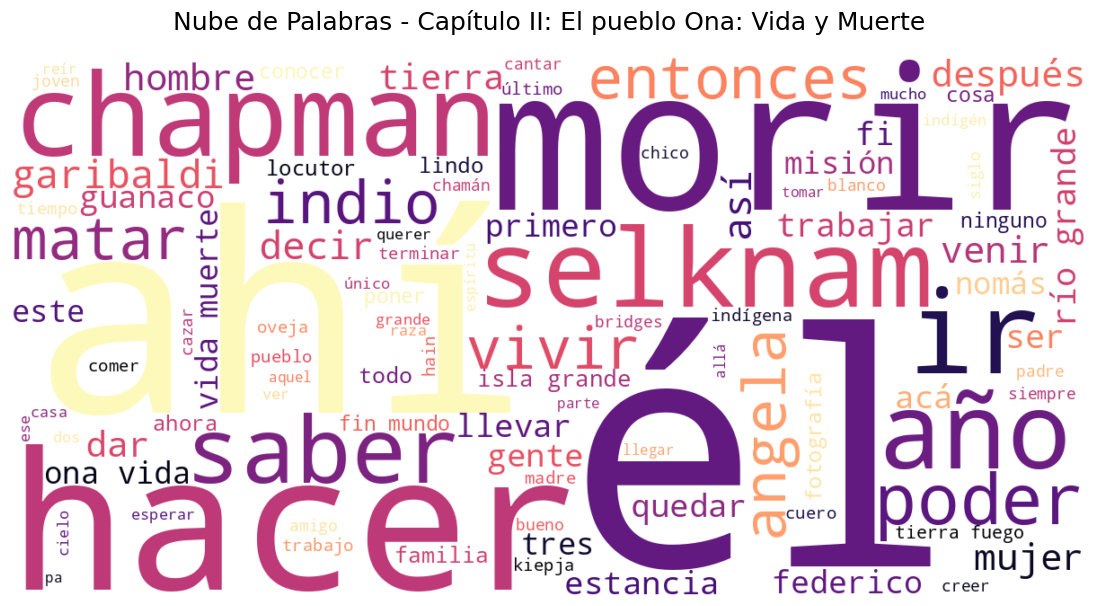

In [22]:
def crear_nube_palabras(lemas):
    wordcloud = WordCloud(width=1200, height=600, background_color='white', colormap='magma',
                         max_words=100, font_path=None).generate(' '.join(lemas))
    plt.figure(figsize=(14, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Nube de Palabras - Capítulo II: El pueblo Ona: Vida y Muerte', fontsize=18, pad=20)
    plt.savefig('nube_palabras.png', dpi=300, bbox_inches='tight')
    plt.show()

crear_nube_palabras(lemas)

## Distribución de entidades

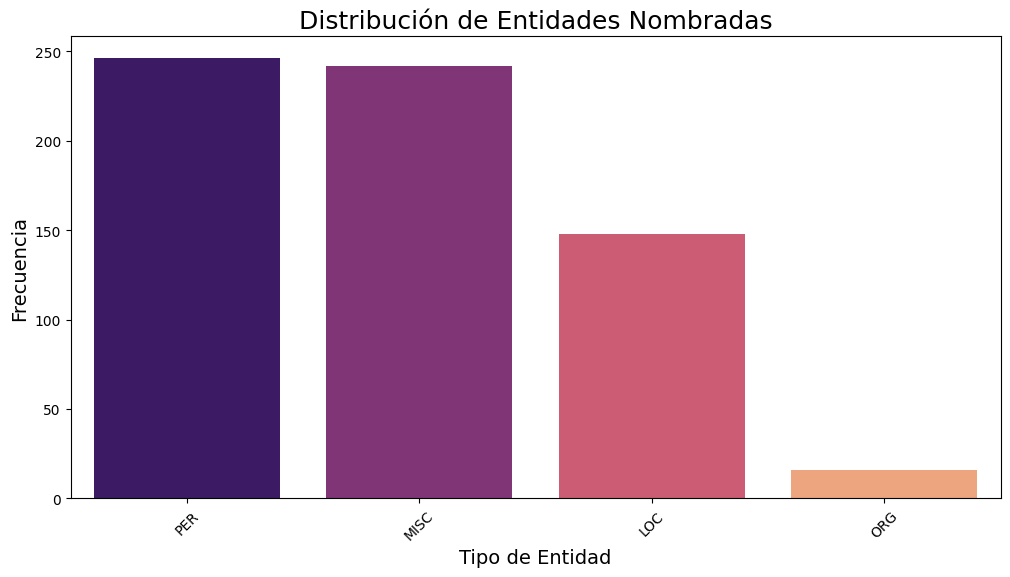

In [23]:
def visualizar_entidades(entidades):
    """Visualiza la distribución de tipos de entidades."""
    df_entidades = pd.DataFrame(entidades, columns=['Entidad', 'Tipo'])
    conteo_tipos = df_entidades['Tipo'].value_counts().reset_index()
    conteo_tipos.columns = ['Tipo', 'Frecuencia']

    plt.figure(figsize=(12, 6))
    sns.barplot(data=conteo_tipos, x='Tipo', y='Frecuencia', palette='magma')
    plt.title('Distribución de Entidades Nombradas', fontsize=18)
    plt.xlabel('Tipo de Entidad', fontsize=14)
    plt.ylabel('Frecuencia', fontsize=14)
    plt.xticks(rotation=45)
    plt.savefig('entidades.png', dpi=300, bbox_inches='tight')
    plt.show()

visualizar_entidades(entidades)

## Temas interactivos con Plotly

In [25]:
def visualizar_temas(temas):
    temas_df = []
    for idx, tema in temas:
        palabras = tema.split('+')
        for palabra in palabras:
            peso, term = palabra.split('*')
            temas_df.append({'Tema': f'Tema {idx+1}', 'Palabra': term.strip('"').strip(), 'Peso': float(peso)})
    df = pd.DataFrame(temas_df)

    fig = px.bar(df, x='Palabra', y='Peso', color='Tema',
                 title='Palabras Clave por Tema (LDA) - Capítulo II',
                 labels={'Peso': 'Peso de la Palabra', 'Palabra': 'Palabras'},
                 height=700)
    fig.update_layout(barmode='stack', xaxis_title="Palabras", yaxis_title="Peso",
                      legend_title="Temas", template="plotly_white", font=dict(size=12))
    fig.write_html('temas_lda.html')
    fig.show()

visualizar_temas(temas)

## Top palabras clave

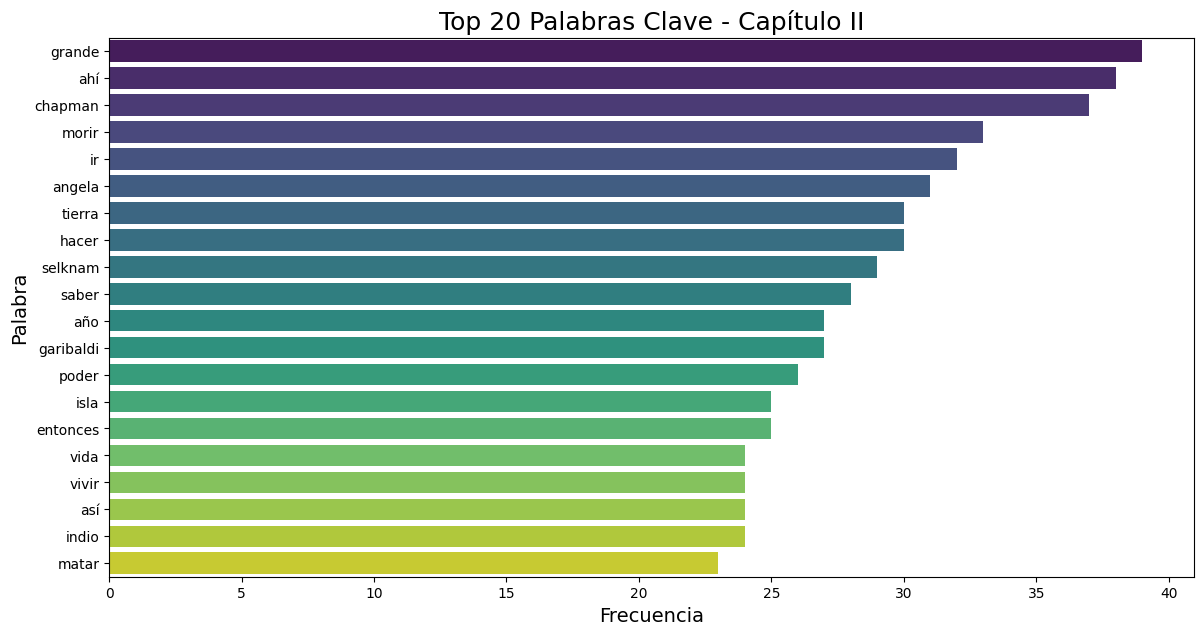

In [27]:
def visualizar_palabras_clave(lemas):
    from collections import Counter
    conteo_palabras = Counter(lemas)
    top_palabras = conteo_palabras.most_common(20)
    df_palabras = pd.DataFrame(top_palabras, columns=['Palabra', 'Frecuencia'])

    plt.figure(figsize=(14, 7))
    sns.barplot(data=df_palabras, x='Frecuencia', y='Palabra', palette='viridis')
    plt.title('Top 20 Palabras Clave - Capítulo II', fontsize=18)
    plt.xlabel('Frecuencia', fontsize=14)
    plt.ylabel('Palabra', fontsize=14)
    plt.savefig('palabras_clave.png', dpi=300, bbox_inches='tight')
    plt.show()

visualizar_palabras_clave(lemas)

## Mapa de Tierra del Fuego

In [28]:
def crear_mapa():
    mapa = folium.Map(location=[-53.79, -67.7], zoom_start=7, tiles='OpenStreetMap')
    marker_cluster = MarkerCluster().add_to(mapa)

    lugares = [
        ('Río Grande', -53.786, -67.700, 'Ciudad mencionada en entrevistas'),
        ('Isla Dawson', -53.966, -70.533, 'Lugar de misiones salesianas'),
        ('Lago Fagnano', -54.516, -67.316, 'Área de ocupación Selk’nam')
    ]

    for nombre, lat, lon, desc in lugares:
        folium.Marker([lat, lon], popup=f"{nombre}: {desc}", tooltip=nombre).add_to(marker_cluster)

    mapa.save('mapa_tierra_del_fuego.html')
    print("Mapa guardado como 'mapa_tierra_del_fuego.html'. Descarga y abre en un navegador.")

crear_mapa()

Mapa guardado como 'mapa_tierra_del_fuego.html'. Descarga y abre en un navegador.


# 10. Resultados y conclusiones

Se guardan los resultados en un archivo de texto para referencia o si llegara a necesitar para la realización de algun informe.

In [31]:
with open('resultados_nlp_capitulo_ii.txt', 'w', encoding='utf-8') as f:
    f.write("# Resultados del Análisis NLP - Capítulo II: El pueblo Ona\n\n")
    f.write("## Tokenización y limpieza\n")
    f.write(f"Primeros 10 tokens limpios: {tokens_limpios[:10]}\n\n")
    f.write("## Lematización\n")
    f.write(f"Primeros 10 lemas: {lemas[:10]}\n\n")
    f.write("## Análisis de sentimientos\n")
    f.write(f"TextBlob: {sentimiento_tb}, Polaridad: {polaridad_tb:.2f}, Subjetividad: {subjetividad_tb:.2f}\n")
    f.write(f"VADER: {sentimiento_vd}, Polaridad: {polaridad_vd:.2f}\n\n")
    f.write("## Entidades nombradas\n")
    f.write(f"Primeras 10 entidades: {entidades[:10]}\n\n")
    f.write("## Modelado de temas (LDA)\n")
    f.write(f"Coherencia del modelo (C_V): {coherencia:.2f}\n")
    for idx, tema in temas:
        f.write(f"Tema {idx+1}: {tema}\n")
    f.write("\n## Visualizaciones\n")
    f.write("Se generaron: nube de palabras, distribución de entidades, temas LDA y top palabras clave.\n")
    f.write("Mapa interactivo de Tierra del Fuego guardado como 'mapa_tierra_del_fuego.html'.\n")

files.download('resultados_nlp_capitulo_ii.txt')
files.download('nube_palabras.png')
files.download('entidades.png')
files.download('palabras_clave.png')
files.download('temas_lda.html')
files.download('mapa_tierra_del_fuego.html')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 11. Conclusiones

Este análisis NLP del Capítulo II revela la riqueza cultural de los Selk’nam, destacando su vida nómada, espiritualidad y el impacto de la colonización. Las visualizaciones muestran términos clave como 'selk’nam', 'hain' y 'guanaco', mientras que los temas LDA identifican aspectos como la ceremonia del Hain, la caza y las entrevistas con informantes como Ángela Loij. El sentimiento mayormente neutro refleja el tono académico del texto, con matices negativos por la narrativa de la desaparición cultural.

Este proyecto combina técnicas avanzadas de Data Science con un sentido homenaje al legado Selk’nam, no solo desde una mirada investigativa, sino también personal. Como alguien nacido y criado en esta tierra, siento el deber y el orgullo de contribuir a la memoria de este pueblo originario, visibilizando su historia a través de la tecnología. Es una obra pensada tanto para el desarrollo profesional como para el reconocimiento cultural.